In [1]:
import collections
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms
import getpass
import glob
import itertools
import json
import numpy as np
import os
import openml
import pandas as pd
import scipy.stats

from plot_utils.style import style_dc
from plot_utils.common_plots import rank, average_plot
from plot_utils.common_tables import collect_data_for_final_table, do_wilcoxon_test
from plot_utils.common_loading import load_from_openml

import sys
sys.path.append("/home/eggenspk/Work/Project/2020_PoSH_Autosklearn/2020_IEEE_Autosklearn_experiments/experiment_scripts/")
sys.path.append("/home/feurerm/sync_dir/projects/2020_posh/2020_IEEE_Autosklearn_experiments/experiment_scripts")
from utils import openml_automl_benchmark, automl_test_benchmark, get_normalization_constants

In [2]:
username = getpass.getuser()
dir_ = {
    'eggenspk': "/home/eggenspk/Work/data/ASKL_20/",
    'feurerm': "/home/feurerm/projects/2021_posh_new/",
}[username]
valid_pretty = {
    #1: {
    #("auto", False, "1MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Auto-sklearn (2.0)",
    #(None, False, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "PoSH-Auto-sklearn",
    #(None, False, "1MIN/ASKL_automldata_baseline_full/RF/RF_None_holdout_full_es_nif"): "Auto-sklearn (1.0)",
    #},
    10: {
    ("auto", False, "10MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Auto-sklearn (2.0)",
    (None, False, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "PoSH-Auto-sklearn",
    (None, False, "10MIN/ASKL_automldata_baseline_full/RF/RF_None_holdout_full_es_nif"): "Auto-sklearn (1.0)",
    },
    60: {
    ("auto", False, "60MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Auto-sklearn (2.0)",
    (None, False, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "PoSH-Auto-sklearn",
    (None, False, "60MIN/ASKL_automldata_baseline_full/RF/RF_None_holdout_full_es_nif"): "Auto-sklearn (1.0)",
    },
}

task_ids = openml_automl_benchmark
#for tid in [189873, 168794, 189874, 189866, 168797, 168796, 75193]:
#    task_ids.remove(tid)
n_seeds = 10
#task_ids = automl_test_benchmark
#n_seeds = 3

print(task_ids, len(task_ids))

res_dc = {}
miss = 0
fallback = 0
for horizon in list(valid_pretty.keys()):
    res_dc[horizon] = {}
    for tid in task_ids:
        res_dc[horizon][tid] = {}
        for mode in list(valid_pretty[horizon].keys()):
            auto, ensemble, model_name = mode
            res_dc[horizon][tid][mode] = []
            for seed in range(n_seeds):
                if auto == "auto":
                    if ensemble:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                    else:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d/result.json" % (tid, seed)

                else:
                    if ensemble:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d_*_0/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                    else:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d_*_0/result.json" % (tid, seed)
                fl = glob.glob(fl_tmpl)               
                if len(fl) == 0:
                    if auto == "auto":
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d/result.json" % (tid, seed)
                    else:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d_*_0/result.json" % (tid, seed)
                    fl = glob.glob(fl_tmpl)
                    if len(fl) == 0:                    
                        miss += 1
                        res_dc[horizon][tid][mode].append({0: 1})
                        print('Missing', fl_tmpl)
                        continue
                    else:
                        fallback += 1
                        print('Ensemble missing, falling back to regular', fl[0])
                        pass
                fl = fl[0]
                with open(fl, "r") as fh:
                    try:
                        line = json.load(fh)
                    except json.JSONDecodeError as e:
                        fh.seek(0)
                        # Some files have two closing brackets...
                        line = json.loads(fh.read()[:-1])
                    except:
                        print(fl)
                        raise
                    if "50" in line:
                        loss = line["50"]["trajectory"]
                    else:
                        loss = line["0"]["trajectory"]
                    loss = [(l[0], l[1]) for l in loss]
                    loss = dict(loss)
                    res_dc[horizon][tid][mode].append(loss)
print("Missing %d entries" % miss)
print("Fallback %d entries" % fallback)

[189871, 189872, 189873, 168794, 168792, 168793, 75105, 189906, 189909, 189908, 167185, 189874, 189861, 189866, 168797, 168796, 189860, 189862, 168798, 189865, 126026, 167104, 167083, 189905, 75127, 167200, 167184, 167201, 168795, 126025, 75097, 167190, 126029, 167149, 167152, 167168, 167181, 75193, 167161] 39
Missing 0 entries
Fallback 0 entries


In [3]:
# Load some stuff from disc and openml - takes some time
tasks, task_ids_sorted_by_num_features = load_from_openml(task_ids)
min_diff_dc, _, _, _, _ = get_normalization_constants(
    results_dir=os.path.join(dir_, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble"),
    task_ids=task_ids,
    load=False,
    n_seeds=n_seeds,
)
tasks

Loaded tasks from openml
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168797 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 Could not find a runhistory for task IDand model selection strategy  168797RF

,tid,ttid,did,name,task_type,status,estimation_procedure,evaluation_measures,source_data,target_feature,...,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,cost_matrix
189871,189871,TaskType.SUPERVISED_CLASSIFICATION,41163,dilbert,Supervised Classification,active,33% Holdout set,NaN,41163,class,...,5.0,1913.0,5.0,2001.0,10000.0,0.0,0.0,2000.0,1.0,NaN
189872,189872,TaskType.SUPERVISED_CLASSIFICATION,41164,fabert,Supervised Classification,active,33% Holdout set,NaN,41164,class,...,7.0,502.0,7.0,801.0,8237.0,0.0,0.0,800.0,1.0,NaN
189873,189873,TaskType.SUPERVISED_CLASSIFICATION,41167,dionis,Supervised Classification,active,33% Holdout set,NaN,41167,class,...,355.0,878.0,355.0,61.0,416188.0,0.0,0.0,60.0,1.0,NaN
168794,168794,TaskType.SUPERVISED_CLASSIFICATION,41165,robert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41165,class,...,10.0,958.0,10.0,7201.0,10000.0,0.0,0.0,7200.0,1.0,NaN
168792,168792,TaskType.SUPERVISED_CLASSIFICATION,41168,jannis,Supervised Classification,active,33% Holdout set,predictive_accuracy,41168,class,...,4.0,1687.0,4.0,55.0,83733.0,0.0,0.0,54.0,1.0,NaN
168793,168793,TaskType.SUPERVISED_CLASSIFICATION,41166,volkert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41166,class,...,10.0,1361.0,10.0,181.0,58310.0,0.0,0.0,180.0,1.0,NaN
75105,75105,TaskType.SUPERVISED_CLASSIFICATION,1111,KDDCup09_appetency,Supervised Classification,active,33% Holdout set,predictive_accuracy,1111,APPETENCY,...,15415.0,890.0,2.0,231.0,50000.0,50000.0,8024152.0,192.0,39.0,NaN
189906,189906,TaskType.SUPERVISED_CLASSIFICATION,40984,segment,Supervised Classification,active,33% Holdout set,NaN,40984,class,...,7.0,330.0,7.0,20.0,2310.0,0.0,0.0,19.0,1.0,NaN
189909,189909,TaskType.SUPERVISED_CLASSIFICATION,41027,jungle_chess_2pcs_raw_endgame_complete,Supervised Classification,active,33% Holdout set,NaN,41027,class,...,3.0,4335.0,3.0,7.0,44819.0,0.0,0.0,6.0,1.0,NaN
189908,189908,TaskType.SUPERVISED_CLASSIFICATION,40996,Fashion-MNIST,Supervised Classification,active,33% Holdout set,NaN,40996,class,...,10.0,7000.0,10.0,785.0,70000.0,0.0,0.0,784.0,1.0,NaN


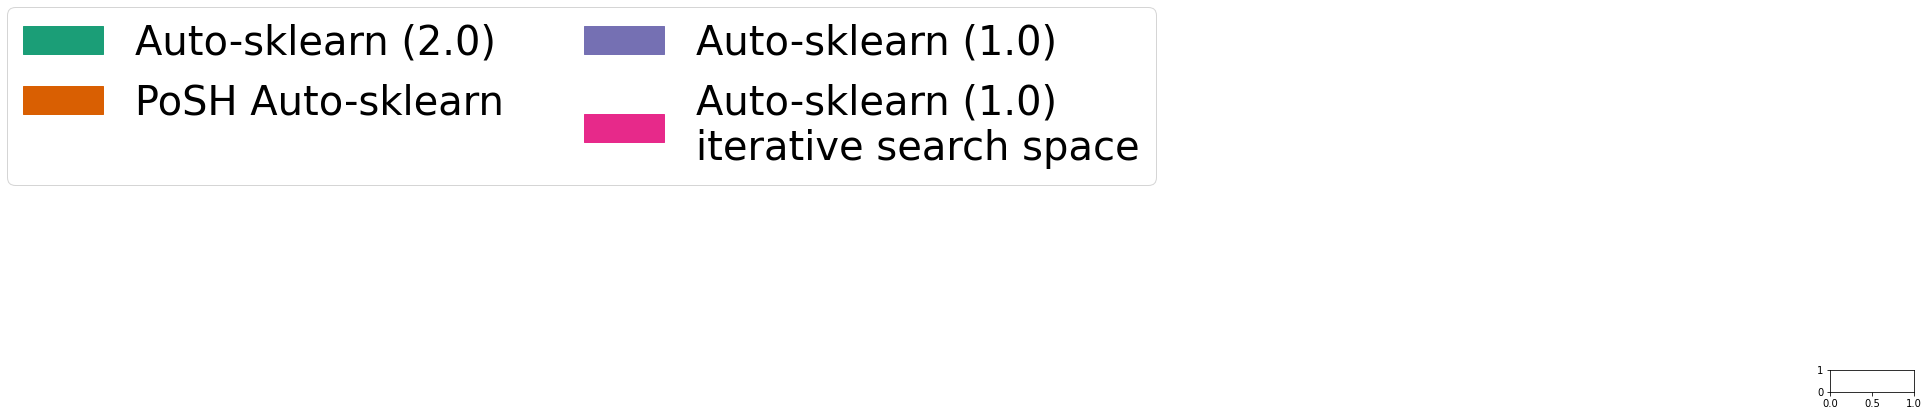

In [4]:
labels = (
    "Auto-sklearn (2.0)",
    "PoSH Auto-sklearn",
    "Auto-sklearn (1.0)",
    "Auto-sklearn (1.0) \niterative search space",
)
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in zip(labels, style_dc['colors'])]
fig.legend(patches, labels, loc='upper left', frameon=True, ncol=2,
           bbox_to_anchor=(0, 1.6, 0, 0), 
           borderaxespad=1., fontsize=style_dc["fontsize"]*2)
box = ax.get_position()
ax.set_position([box.x0 + 1.6, box.y0, box.width * 0.1, box.height * 0.1])
#plt.show()
#plt.tight_layout()
plt.savefig('/tmp/RQ1_legend.pdf', bbox_inches=matplotlib.transforms.Bbox.from_bounds(0, 0, 22, 6))

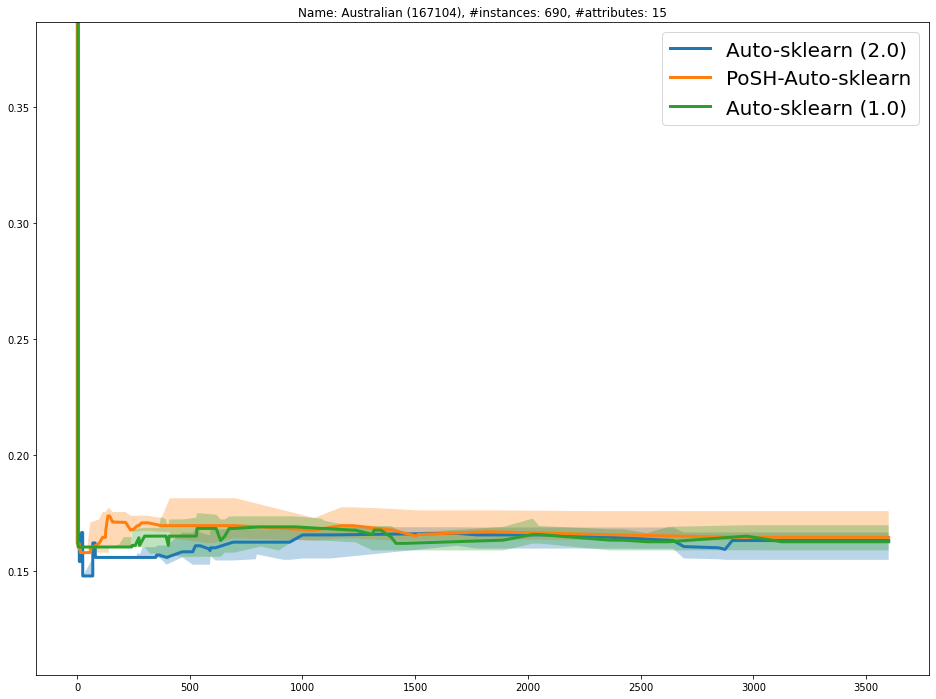

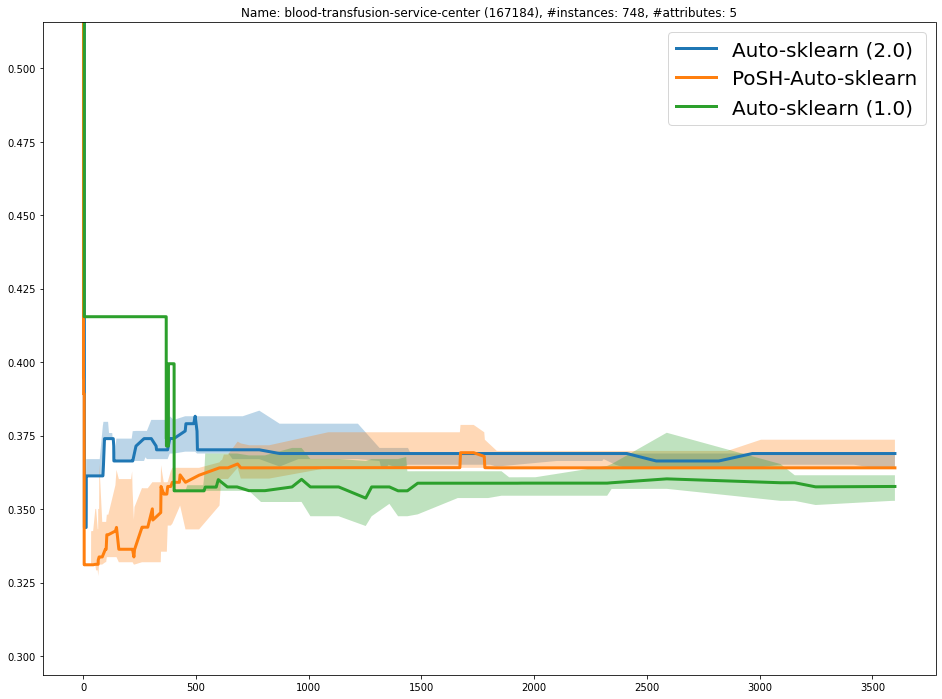

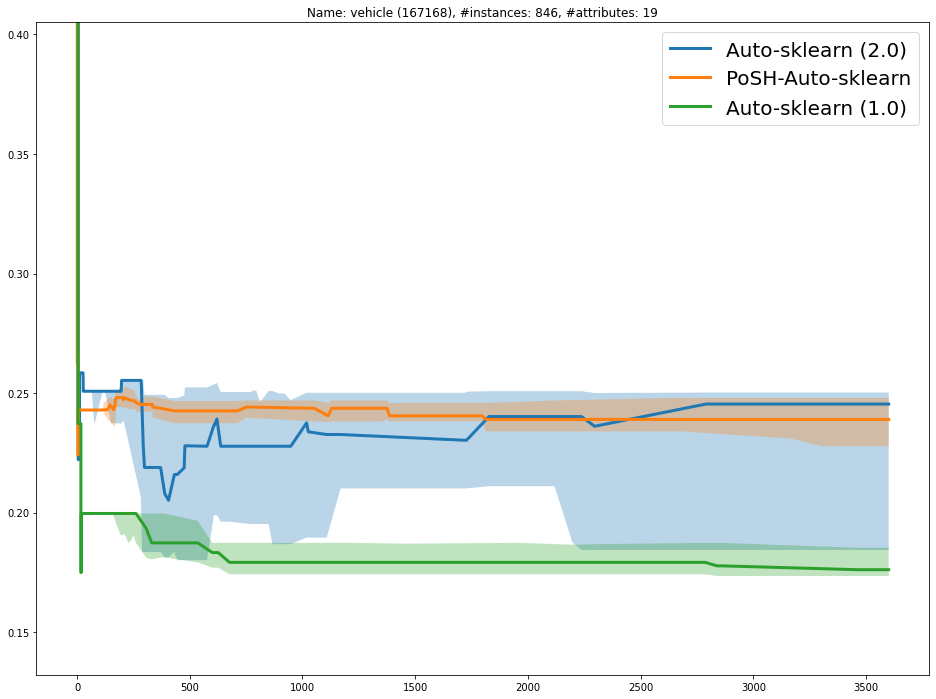

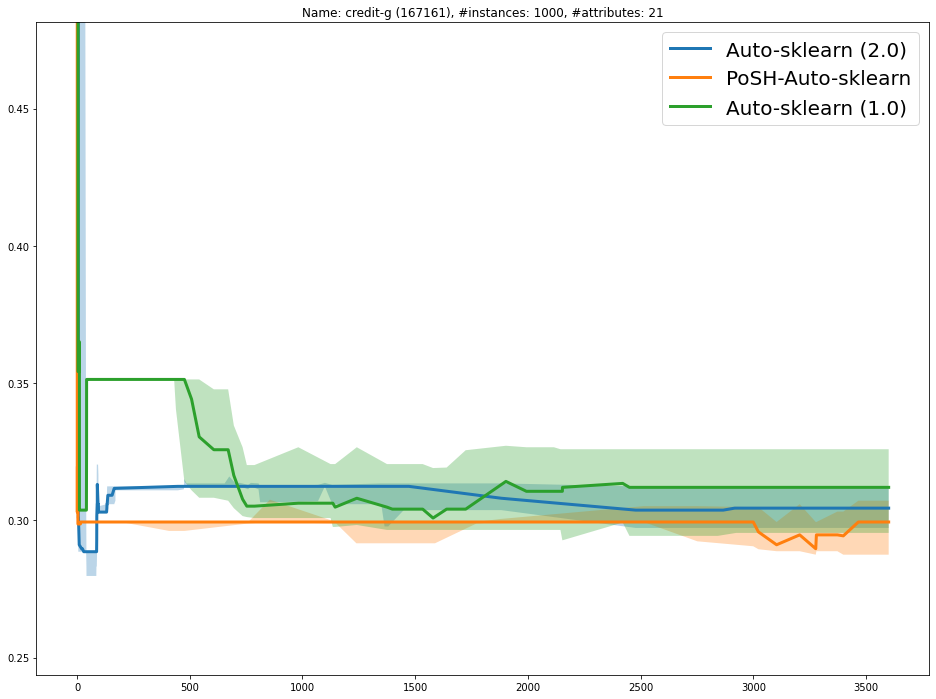

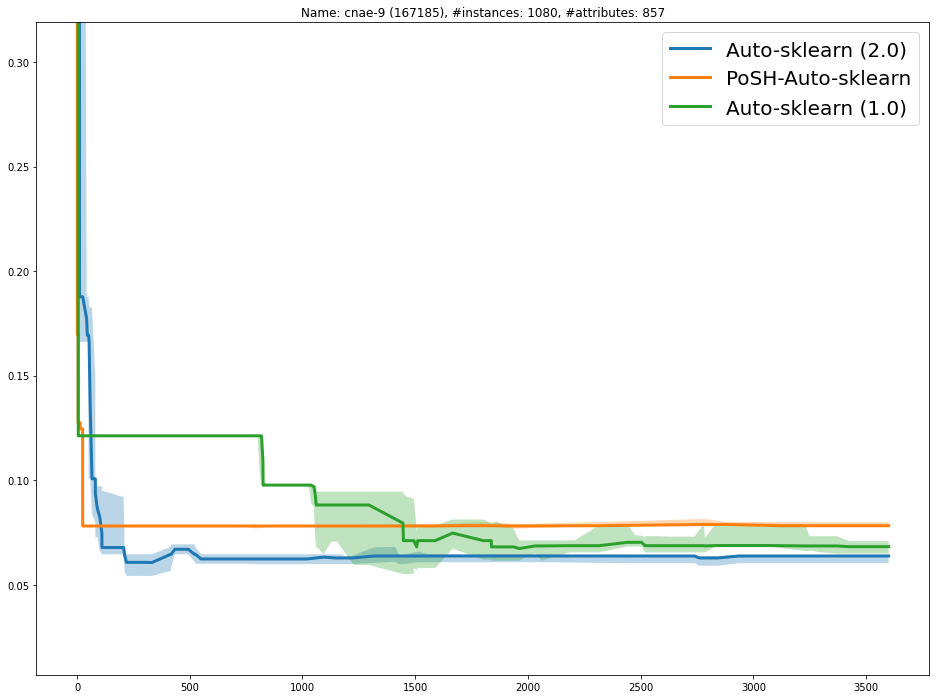

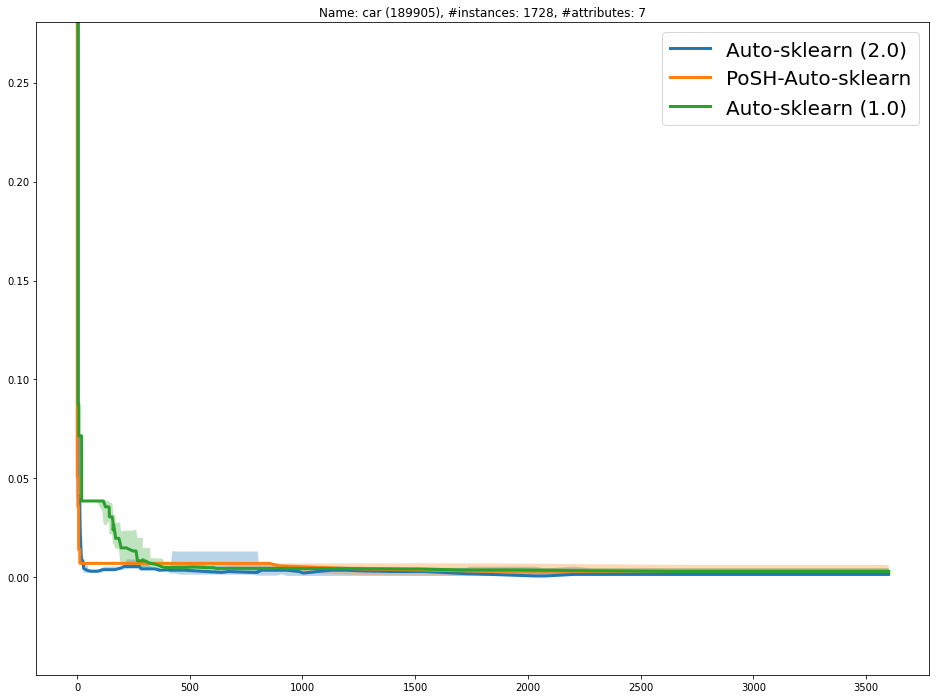

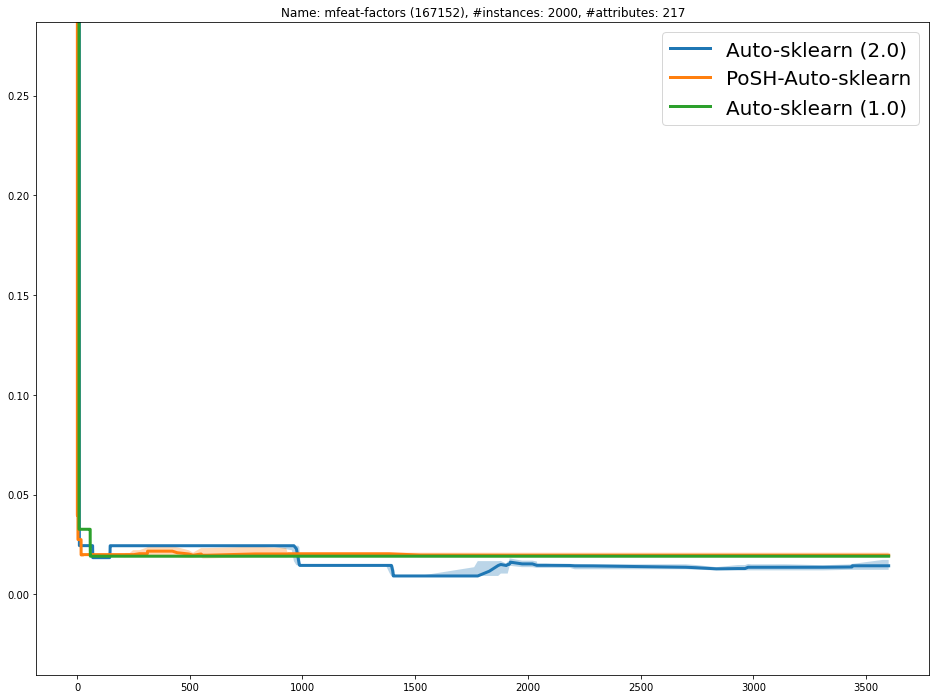

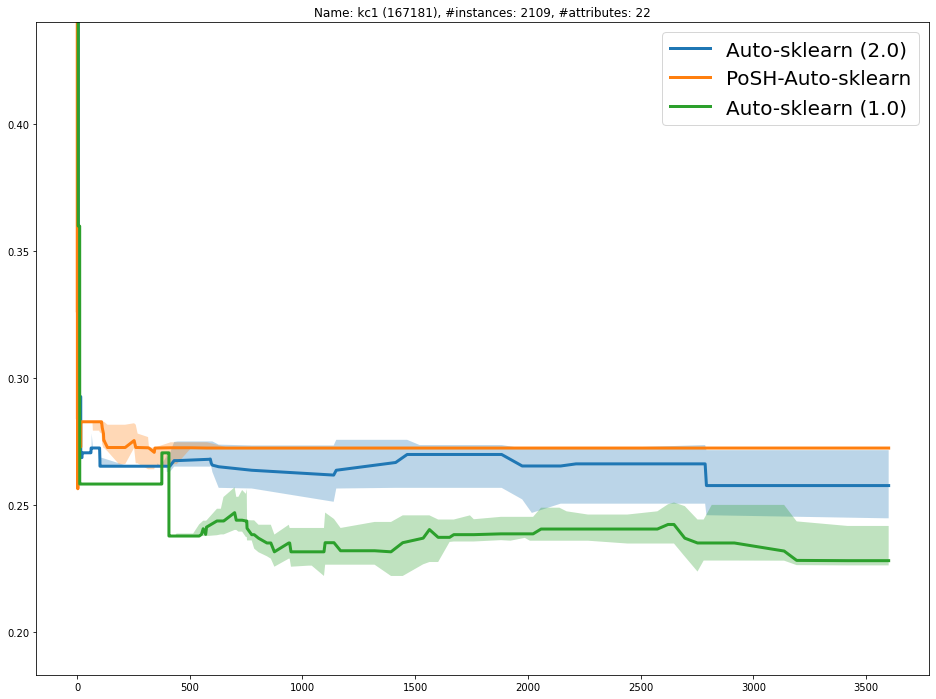

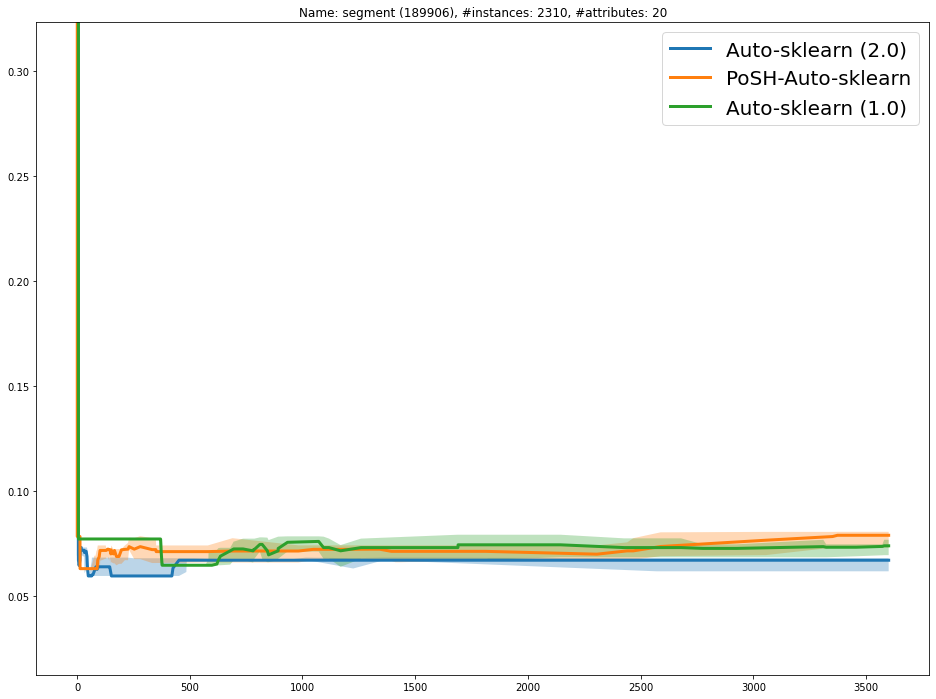

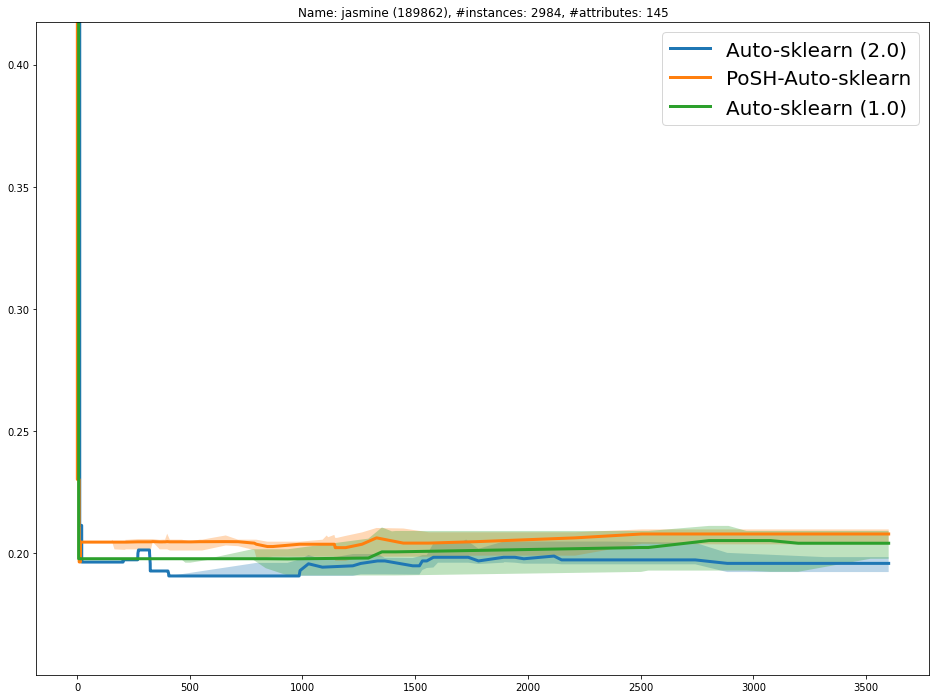

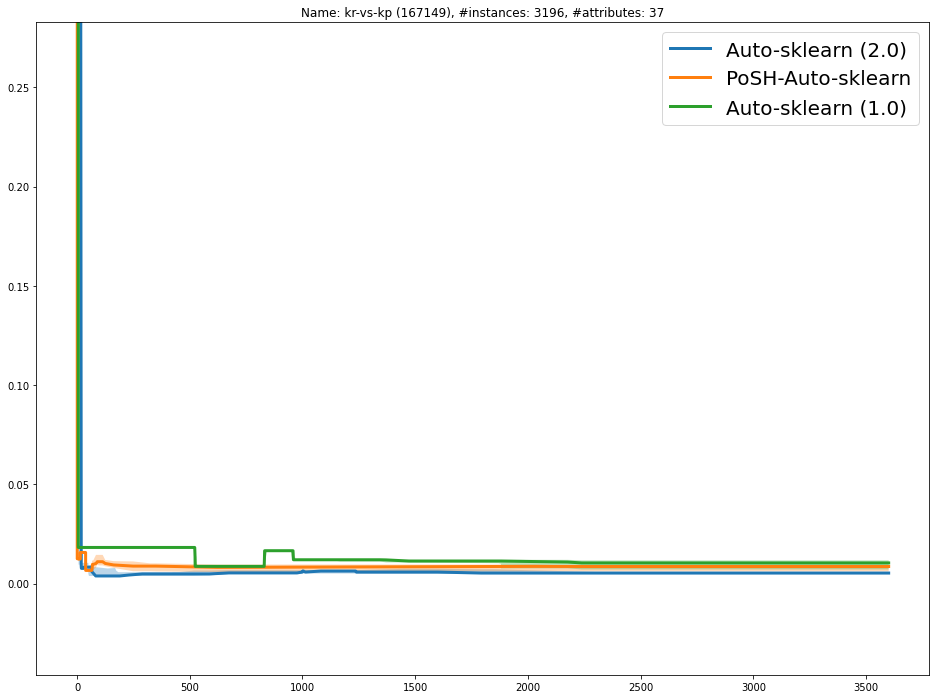

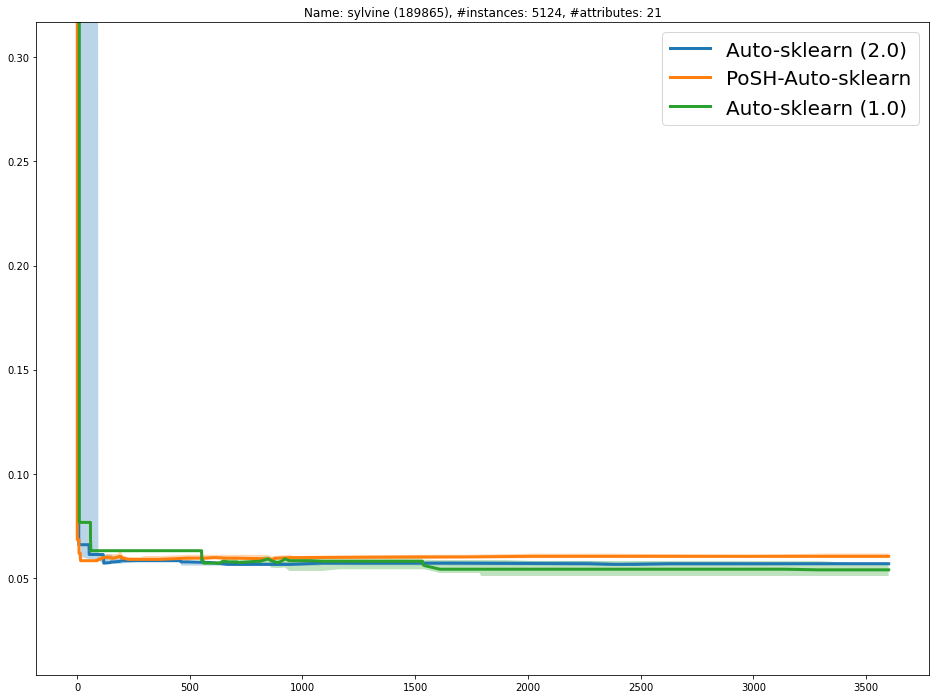

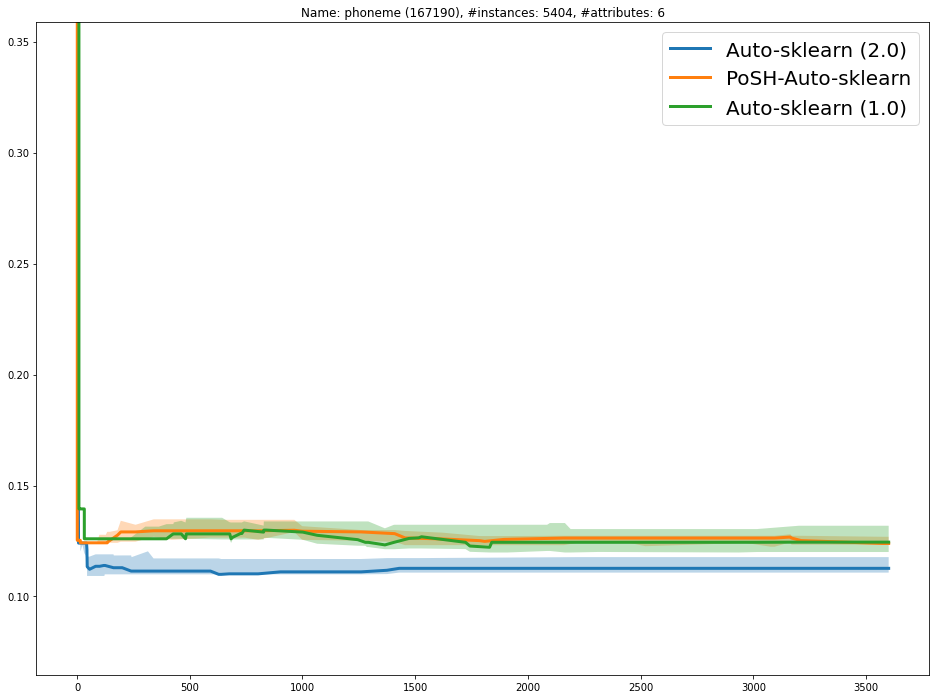

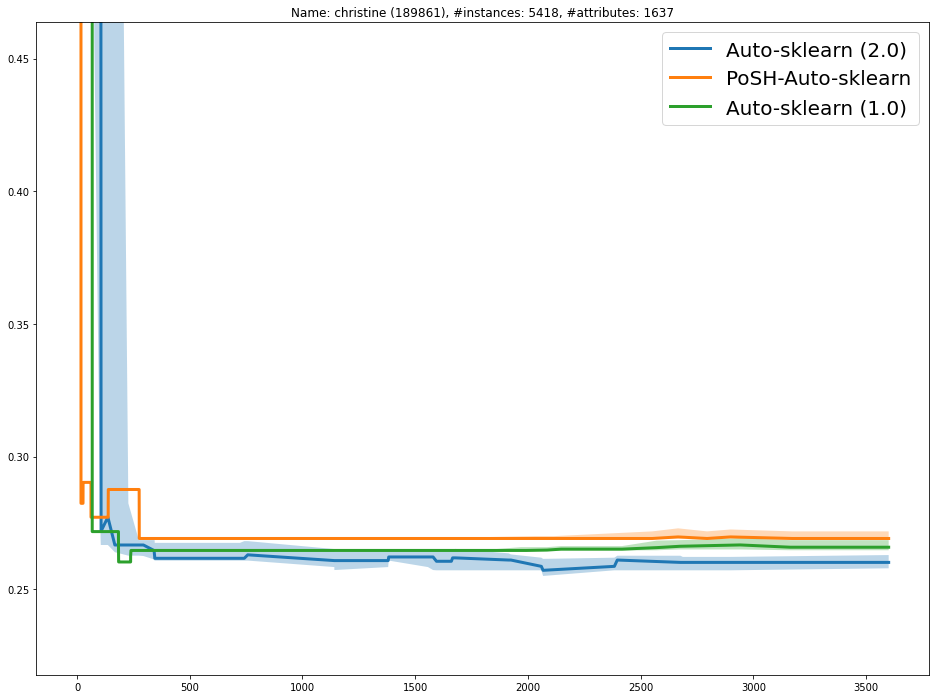

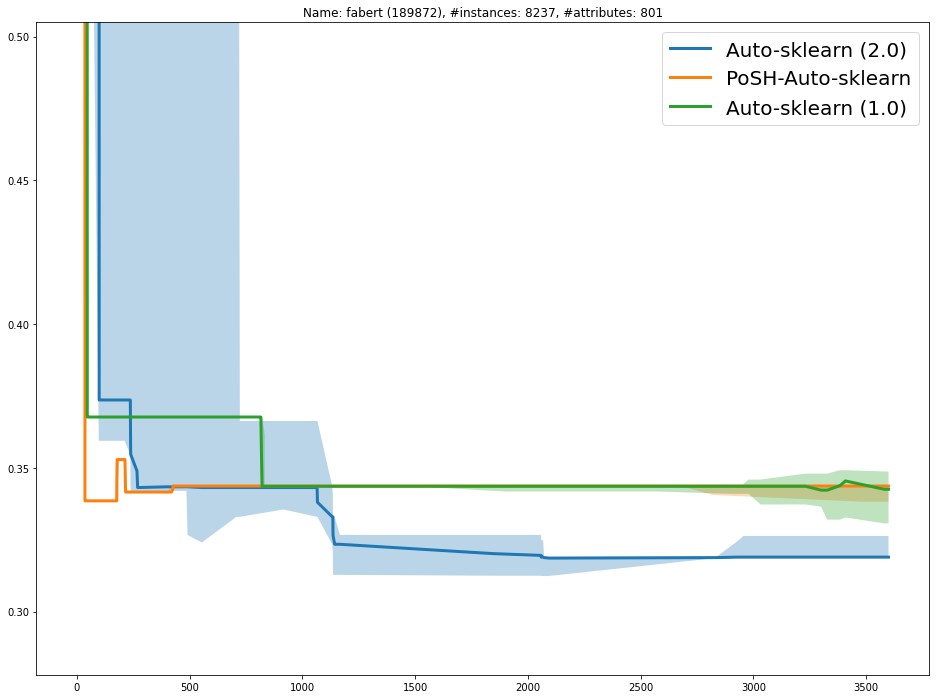

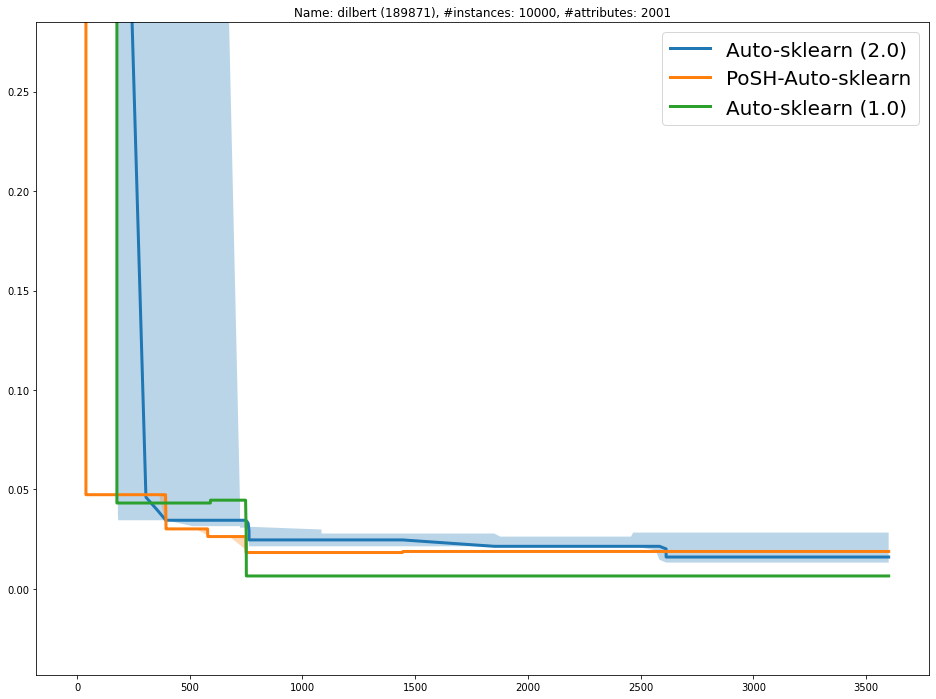

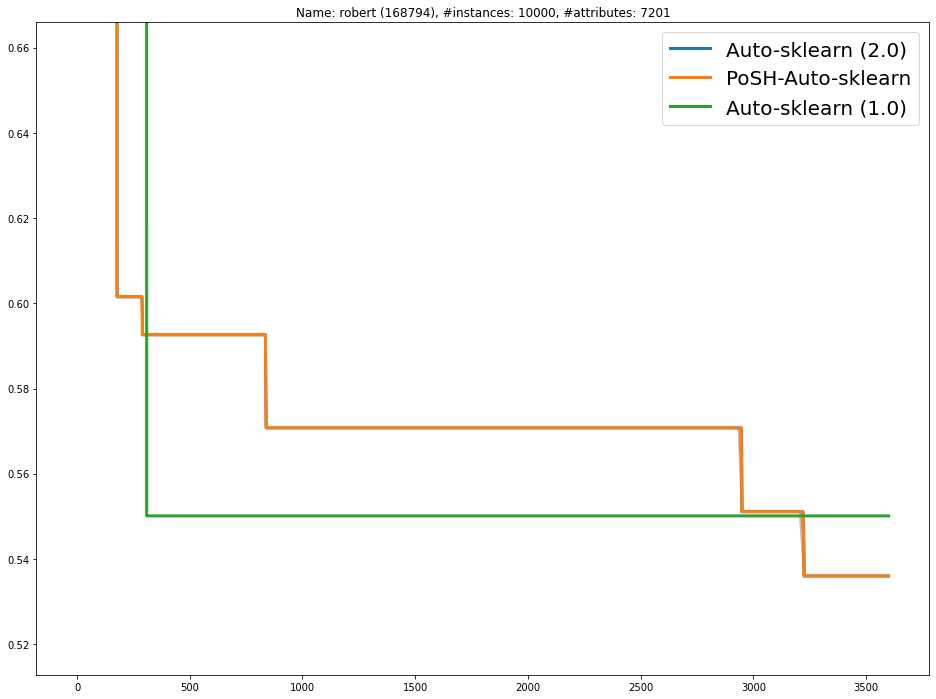

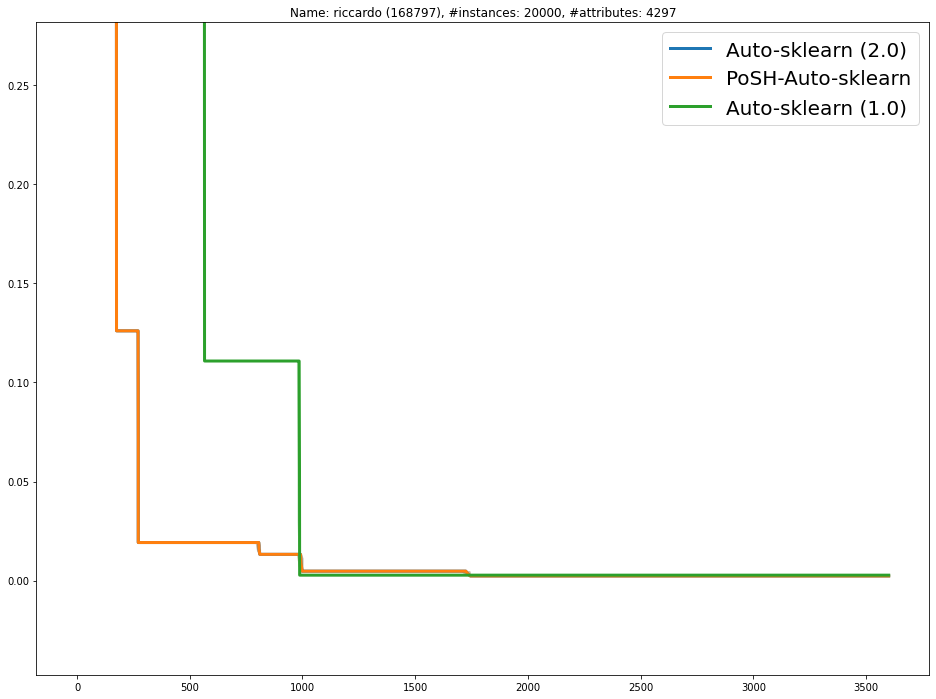

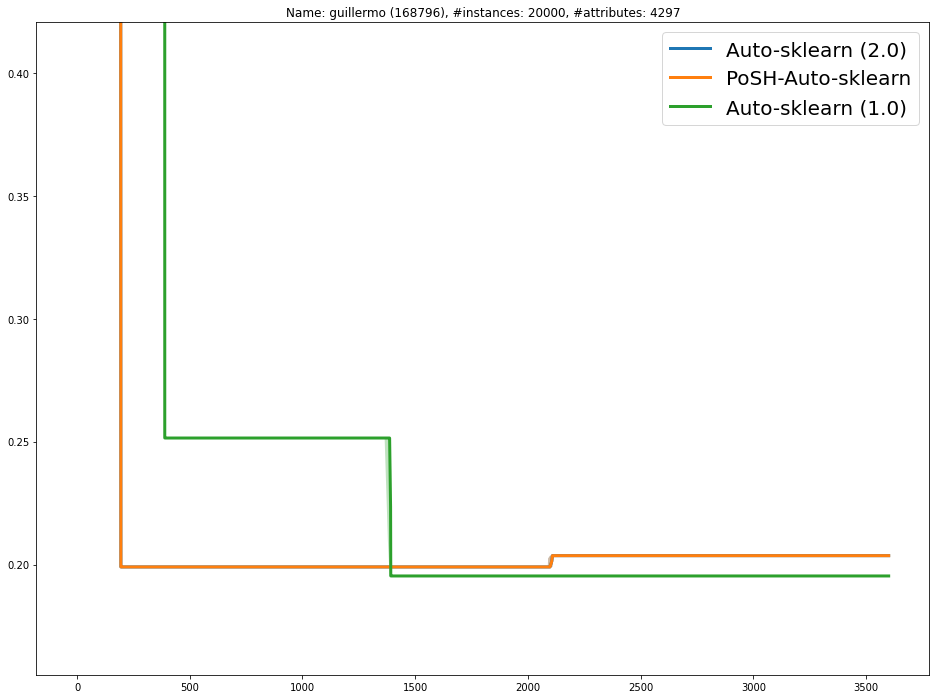

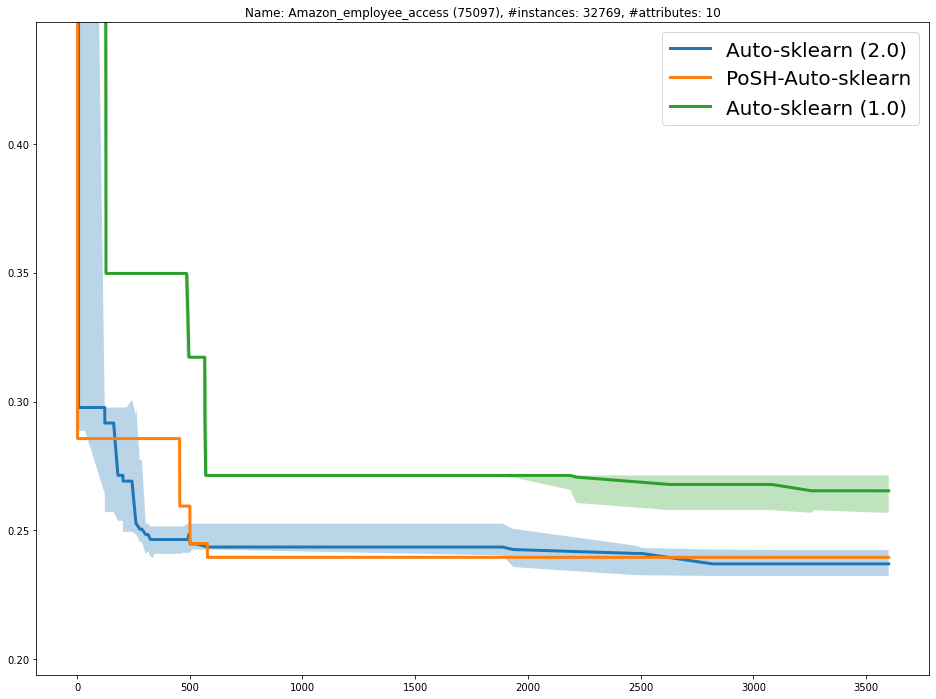

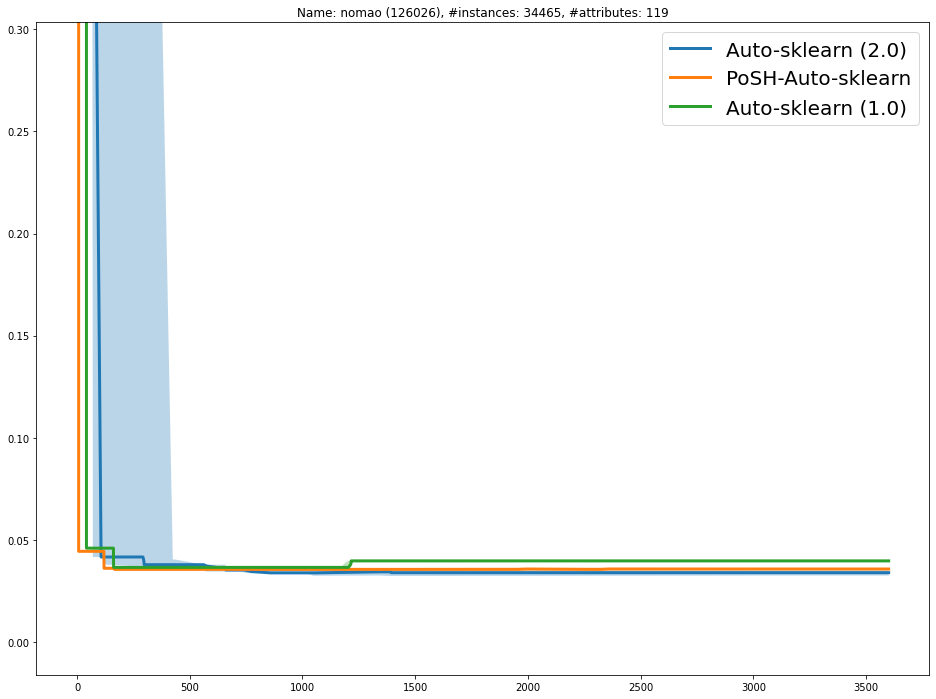

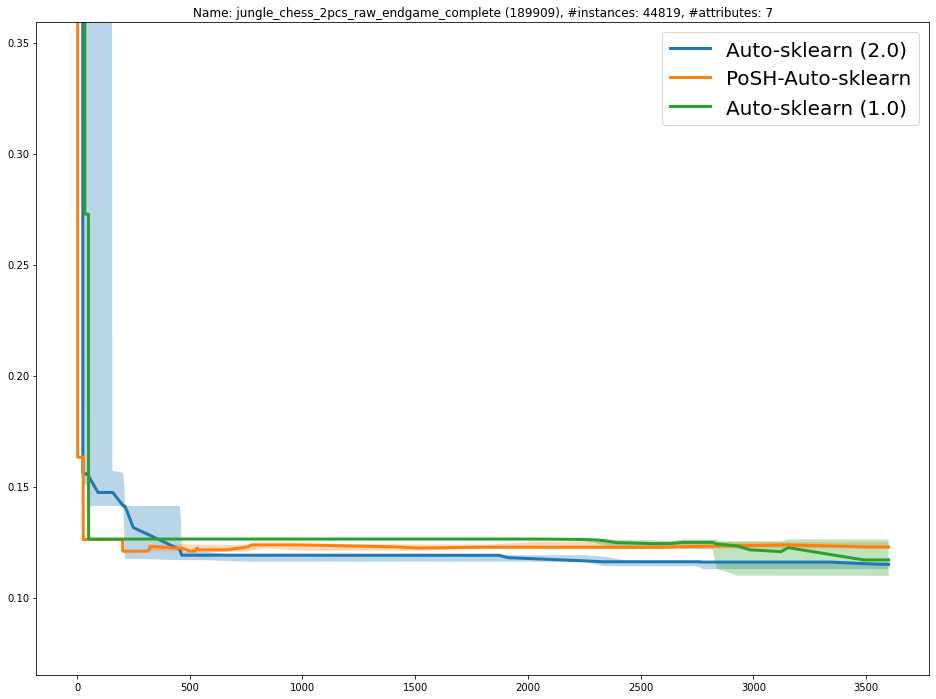

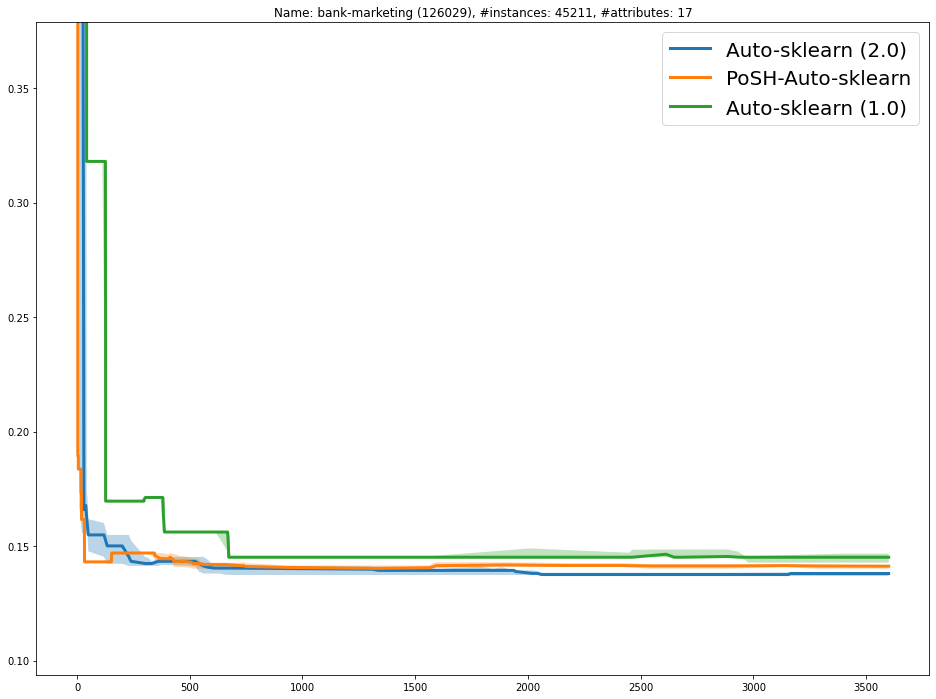

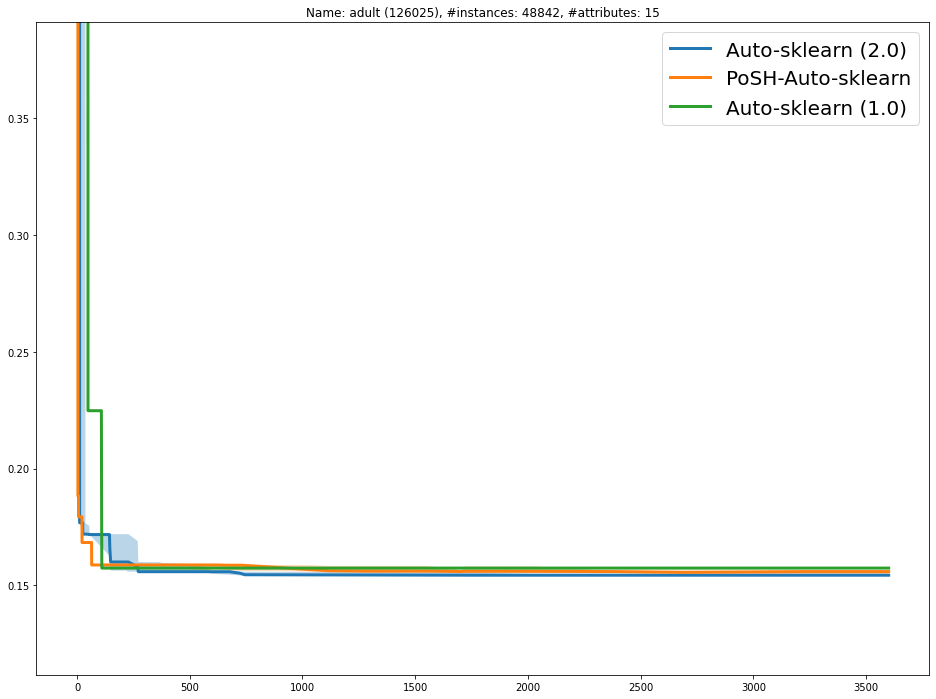

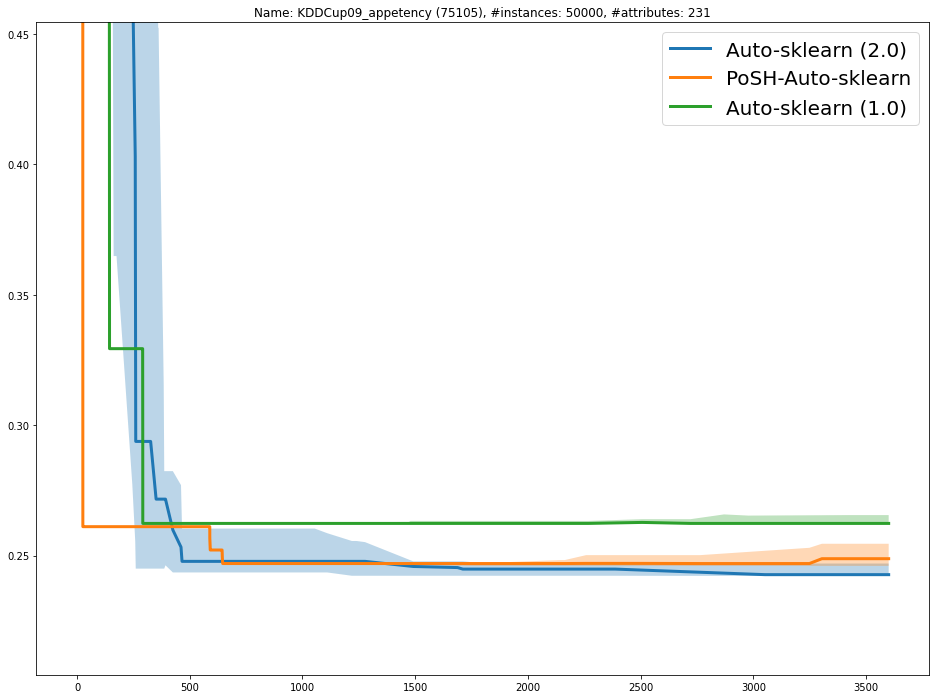

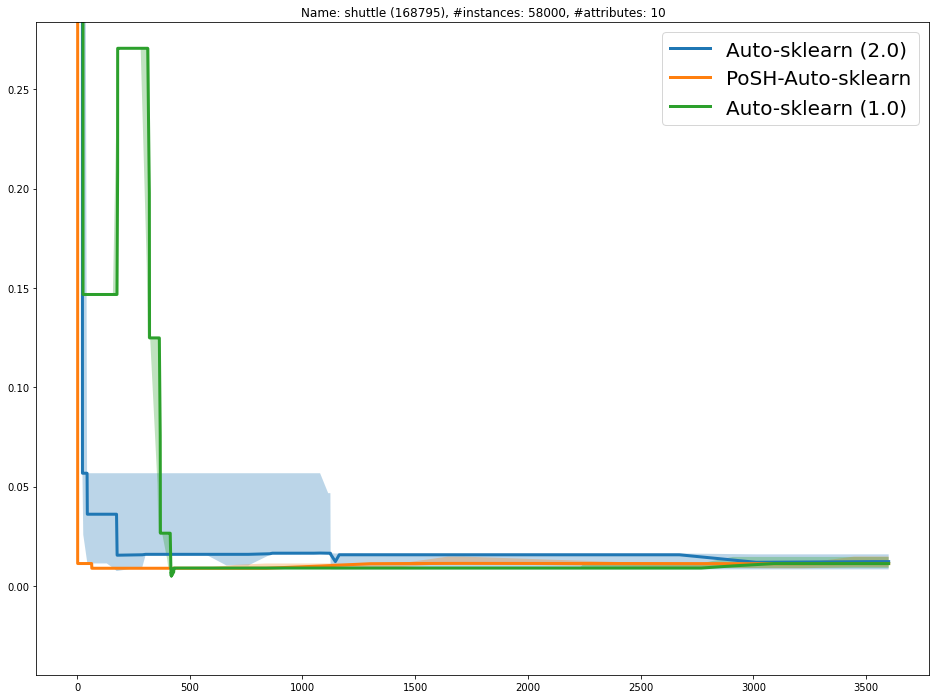

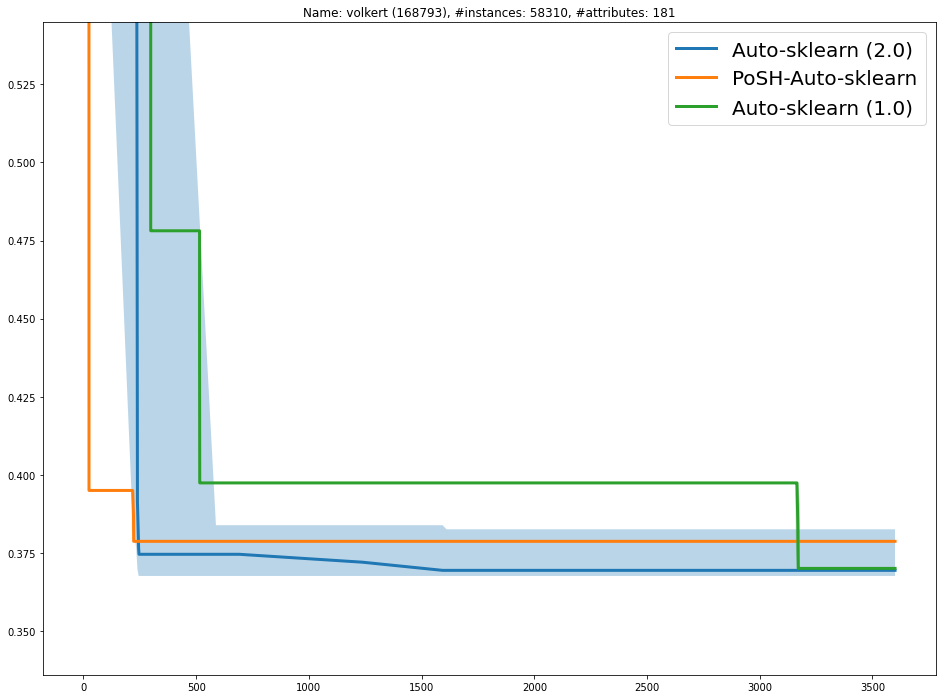

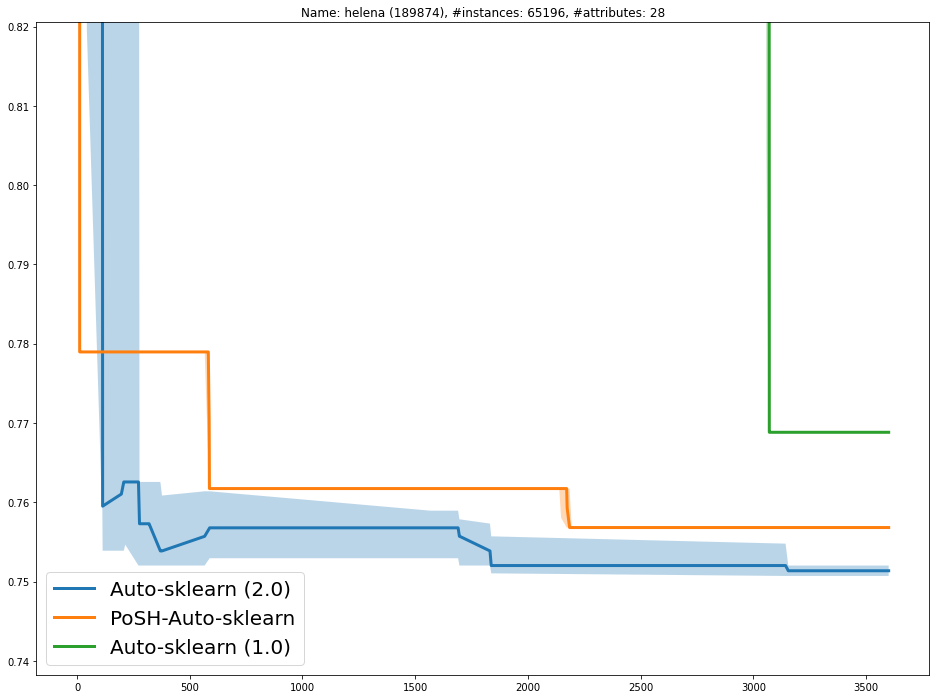

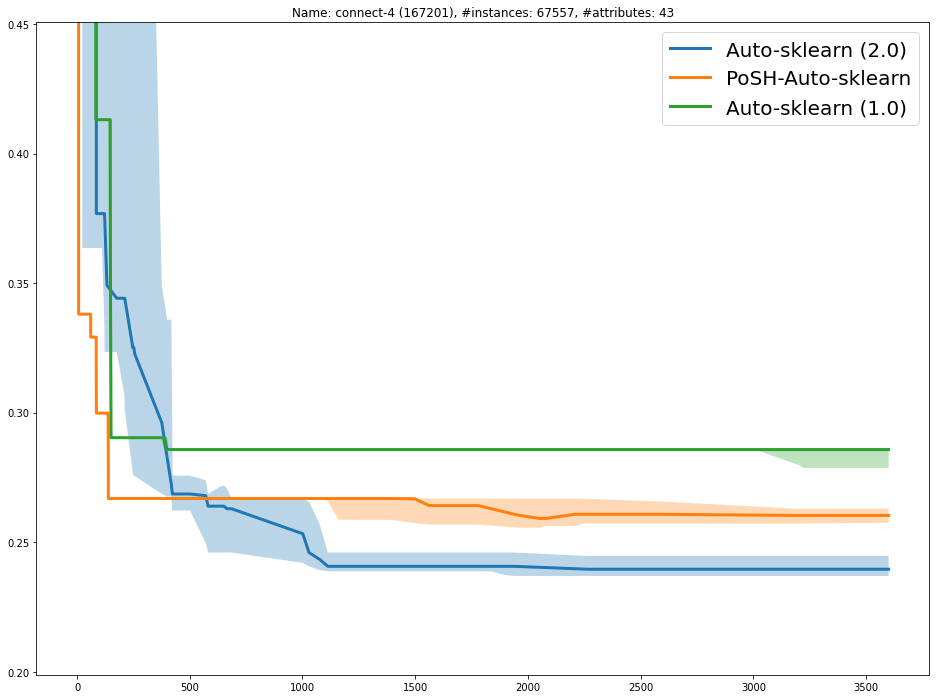

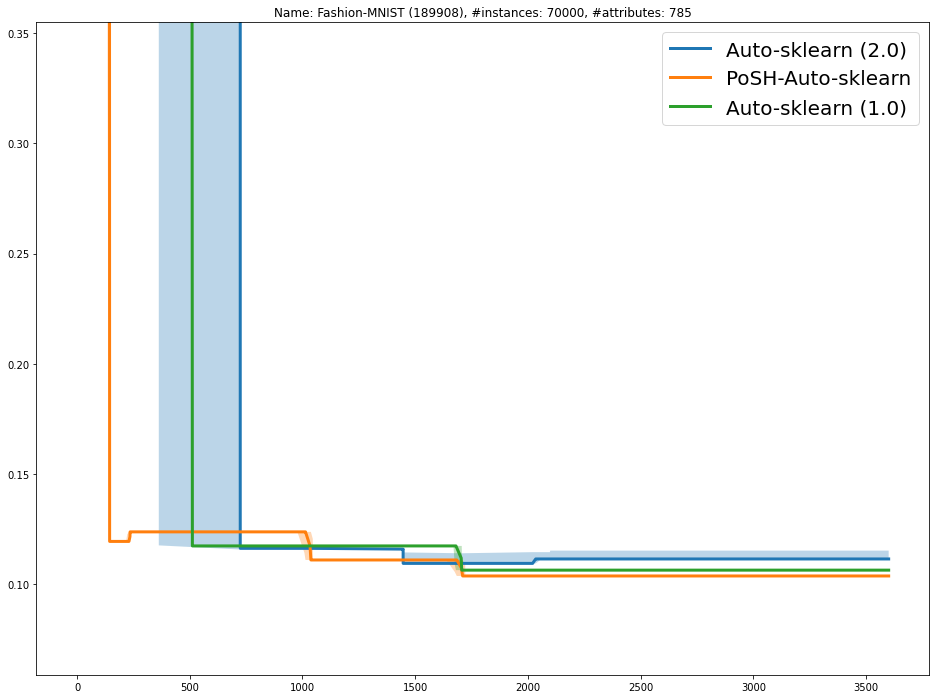

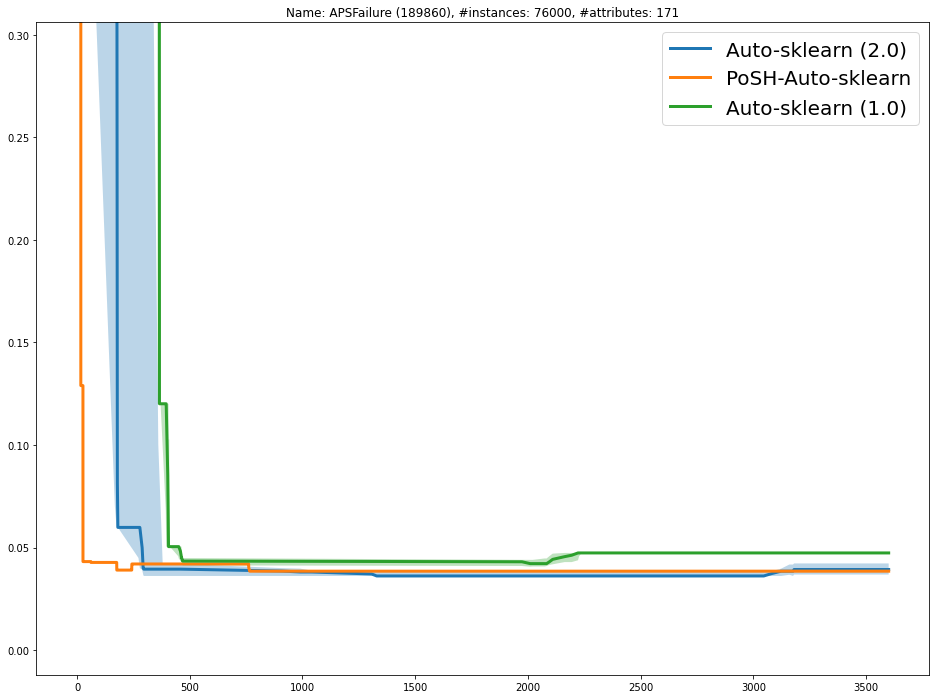

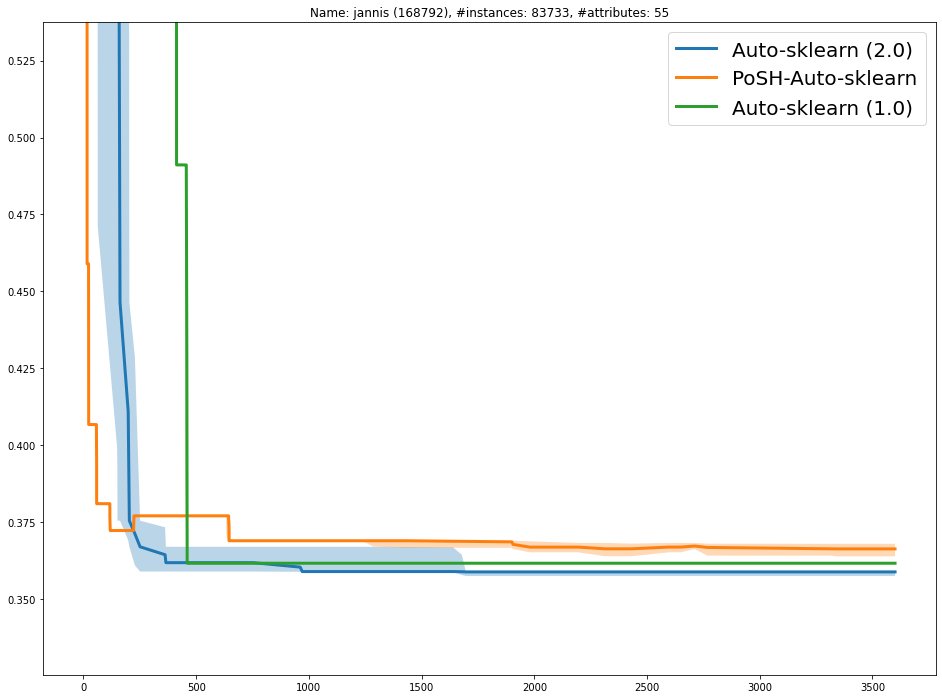

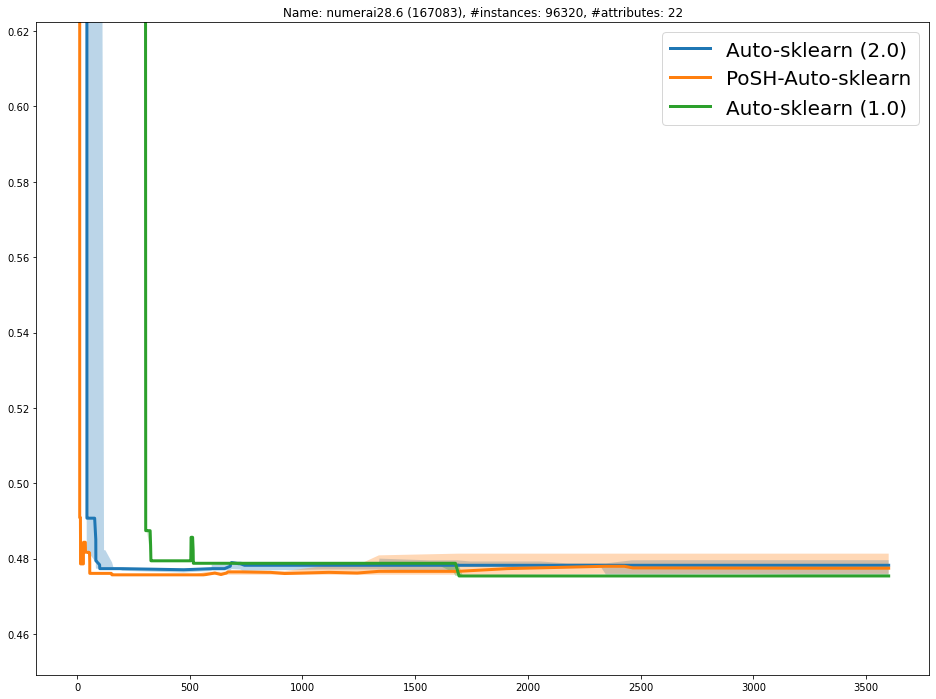

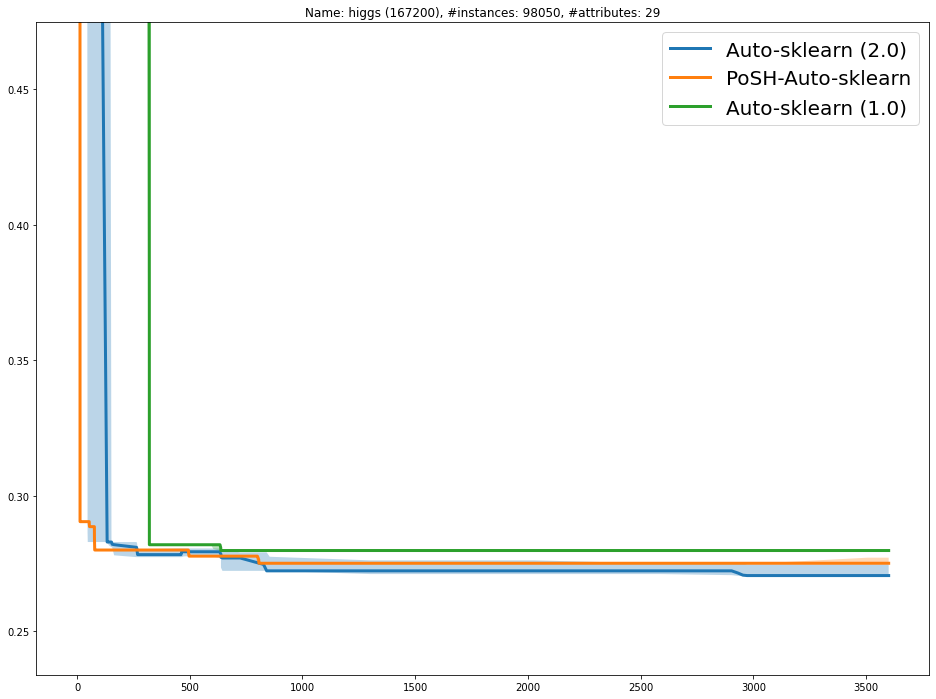

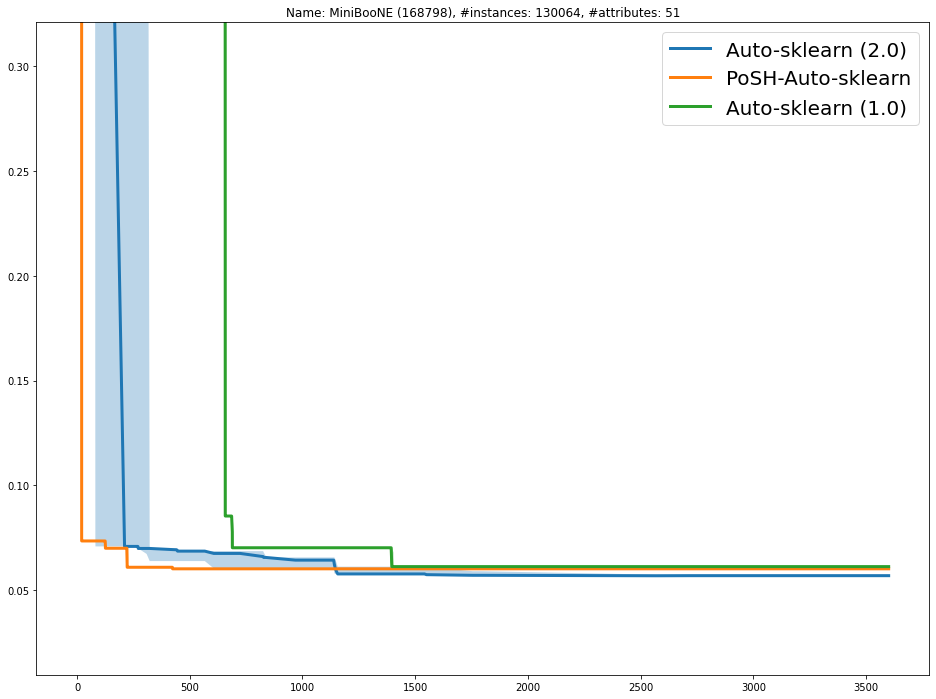

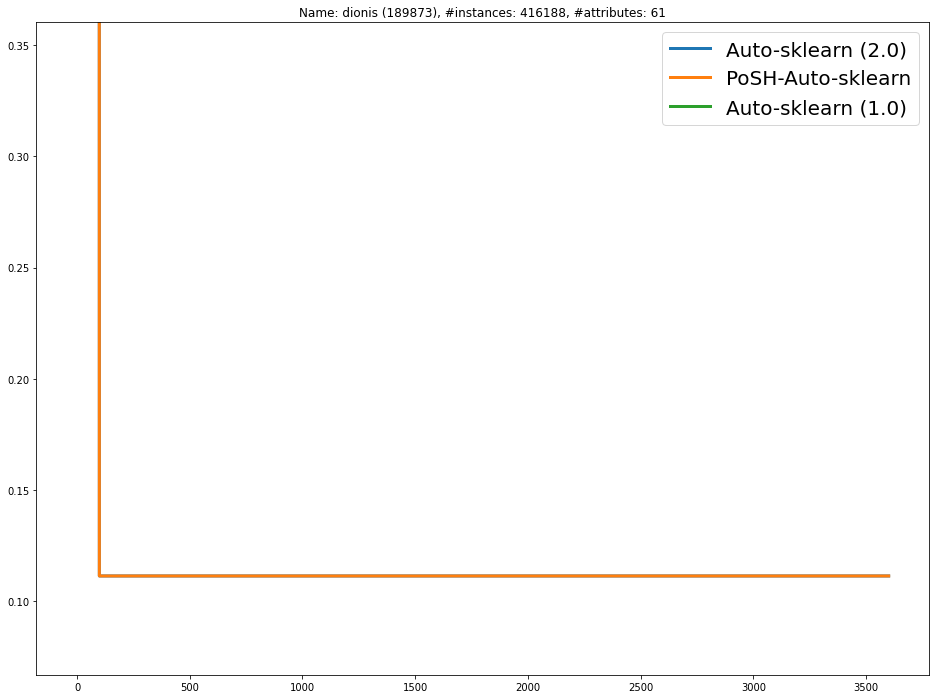

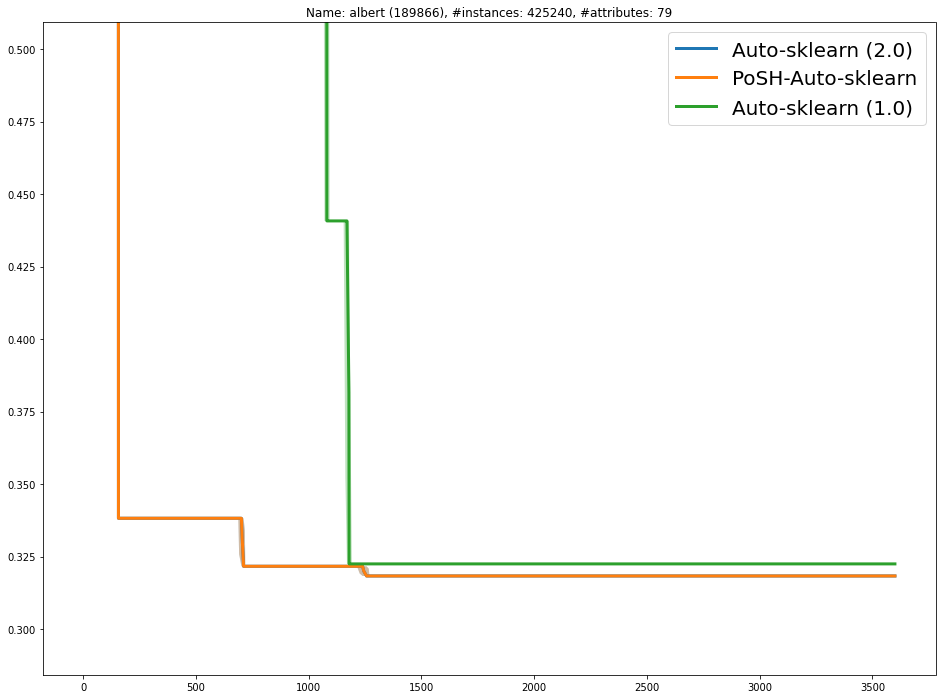

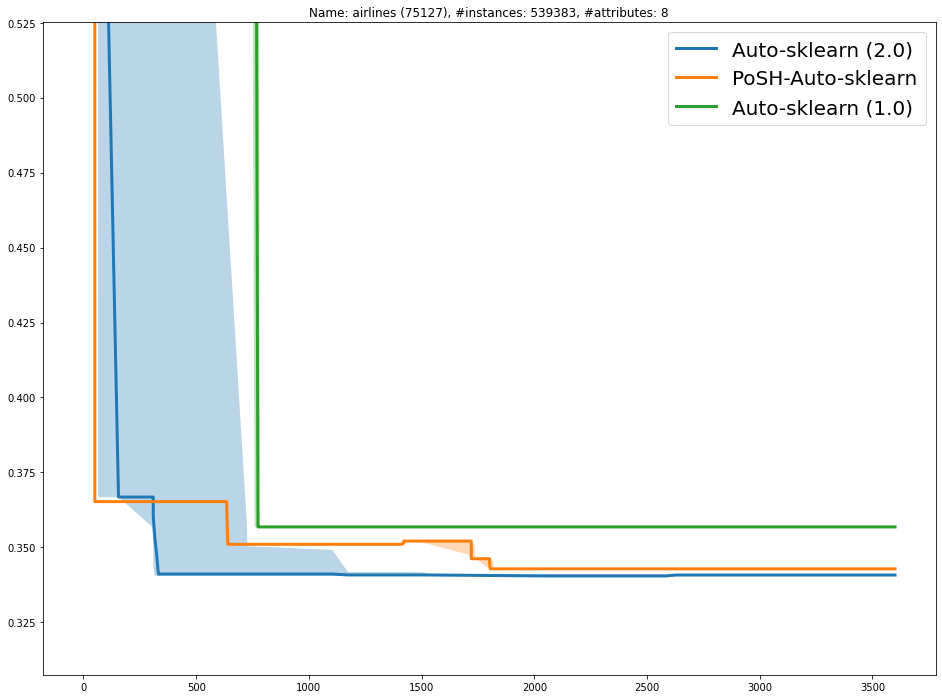

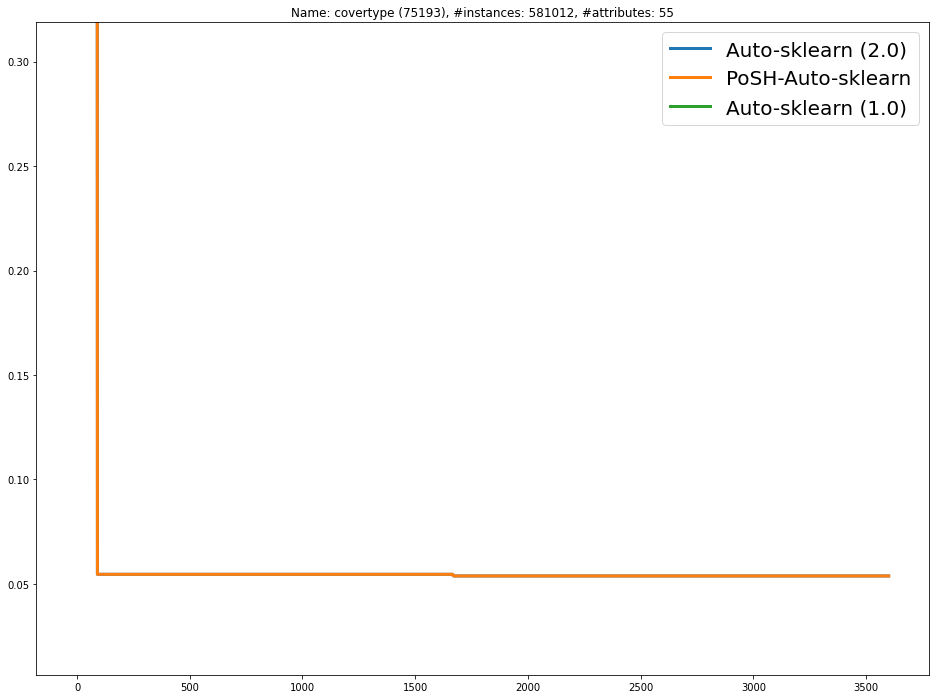

In [5]:
HORIZON = 60
for tid in task_ids_sorted_by_num_features:
    plt.figure(figsize=[16,12])
    colors = itertools.cycle(style_dc['colors'])
    for mode in list(valid_pretty[HORIZON].keys()):
        c = next(colors)
        tmp = pd.DataFrame(res_dc[HORIZON][tid][mode]).sort_index(axis=1).ffill(axis=1)
        med = tmp.median(axis=0)
        med.loc[HORIZON*60] = med.iloc[-1]
        low = tmp.quantile(0.25)
        low.loc[HORIZON*60] = low.iloc[-1]
        up = tmp.quantile(0.75, axis=0)
        up.loc[HORIZON*60] = up.iloc[-1]
        plt.plot(med.index, med.to_numpy(), label=valid_pretty[HORIZON][mode], linewidth=3)
        plt.fill_between(med.index, low, up, alpha=0.3)
    plt.title('Name: %s (%d), #instances: %d, #attributes: %d' % (
        tasks.loc[tid, 'name'], tid, tasks.loc[tid, 'NumberOfInstances'], tasks.loc[tid, 'NumberOfFeatures']))
    plt.legend(fontsize=20)
    plt.ylim([plt.ylim()[0], plt.ylim()[0] + 0.3*(plt.ylim()[1]-plt.ylim()[0])])
    #plt.yscale("log")
    plt.show()

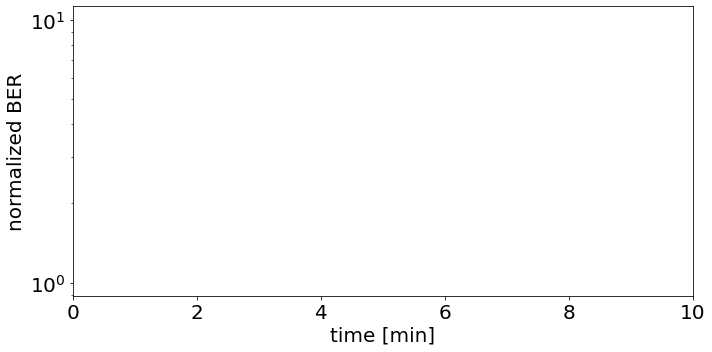

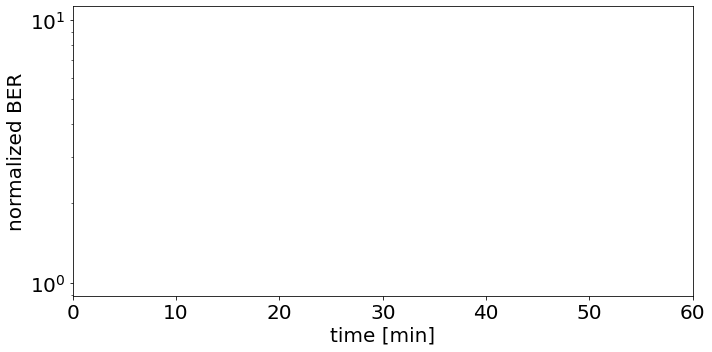

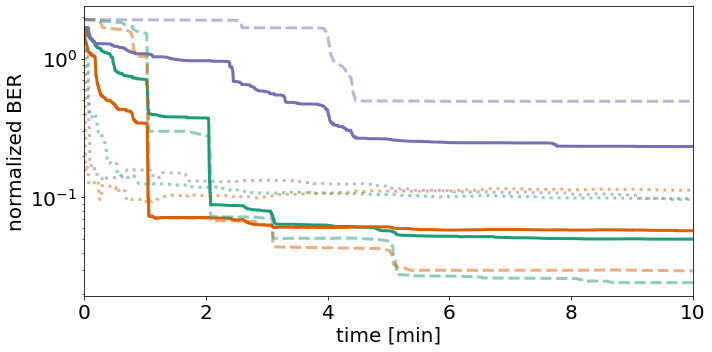

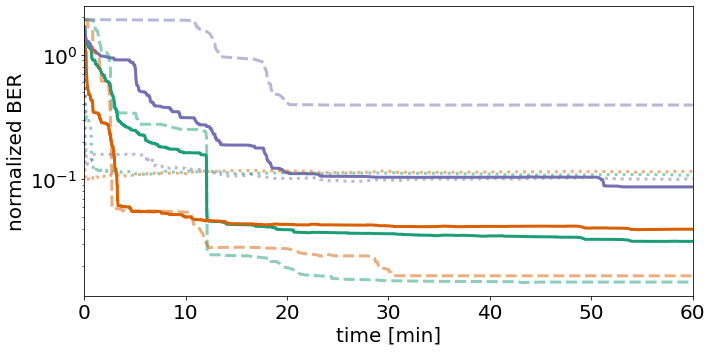

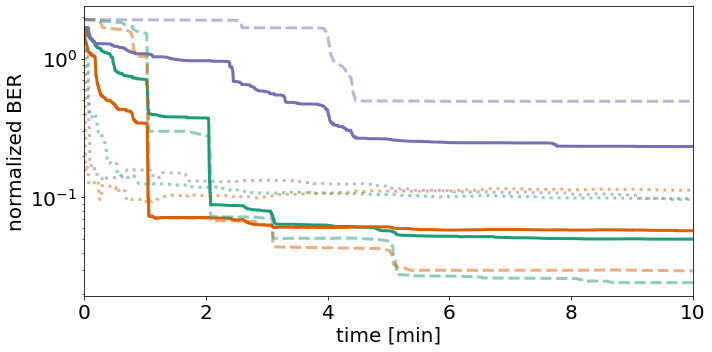

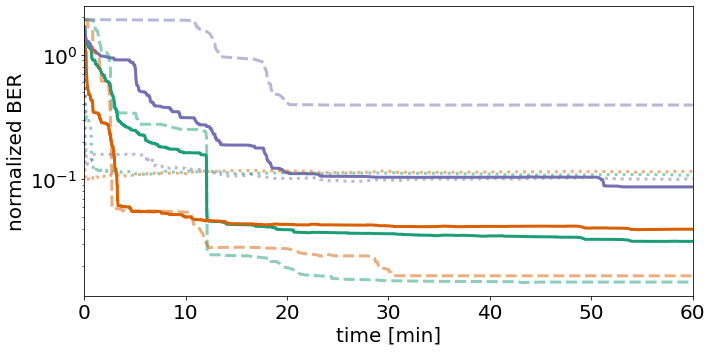

In [6]:
# Plot average BER across all datasets
for use_ensemble in ((True, ), (False, ), (True, False)):
    for HORIZON in (10, 60):
        model_list = []
        for m in valid_pretty[HORIZON].keys():
            if m[1] in use_ensemble:
                model_list.append(m)

        average_plot(model_list=model_list, res_dc=res_dc, valid_pretty=valid_pretty,
                     horizon=HORIZON, task_ids_sorted_by_num_features=task_ids_sorted_by_num_features,
                     min_diff_dc=min_diff_dc, figsize=(10, 5), legend=False)
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig('/tmp/RQ1_%sMIN_%s_perf.pdf' % (
            str(HORIZON), "ens" if use_ensemble[0] is True and len(use_ensemble) == 1 else "other")
        )
        plt.show()

In [7]:
# Assume we have either all or no models
horizon_list = sorted(list(valid_pretty.keys()))
model_list = {}
for h in horizon_list:
    model_list[h] = []
    for m in valid_pretty[h].keys():
        model_list[h].append(m)

tab_data, stat_test_data = collect_data_for_final_table(
    model_list, res_dc, valid_pretty, horizon_list,
    task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, exclude=["Oracle",])

Not different with 10 mins:
	 
Not different with 60 mins:
	 


In [8]:
df = pd.DataFrame(tab_data)
class formatter:
    def __call__(self, value):
        return '$%2.2f$' % value

formatters = [formatter() for _ in range(4)]
print(df)
print(df.to_latex(formatters=formatters, escape=False))
print(not_different)

                       10  STD 10    60  STD 60
Auto-sklearn (2.0)   5.01    0.18  3.18    0.31
PoSH-Auto-sklearn    5.76    0.12  3.97    0.22
Auto-sklearn (1.0)  23.24    0.29  8.68    0.21
\begin{tabular}{lrrrr}
\toprule
{} &      10 & STD 10 &     60 & STD 60 \\
\midrule
Auto-sklearn (2.0) &  $5.01$ & $0.18$ & $3.18$ & $0.31$ \\
PoSH-Auto-sklearn  &  $5.76$ & $0.12$ & $3.97$ & $0.22$ \\
Auto-sklearn (1.0) & $23.24$ & $0.29$ & $8.68$ & $0.21$ \\
\bottomrule
\end{tabular}

{10: [], 60: []}


Plotting 3 models
0 / 200
50 / 200
100 / 200
150 / 200


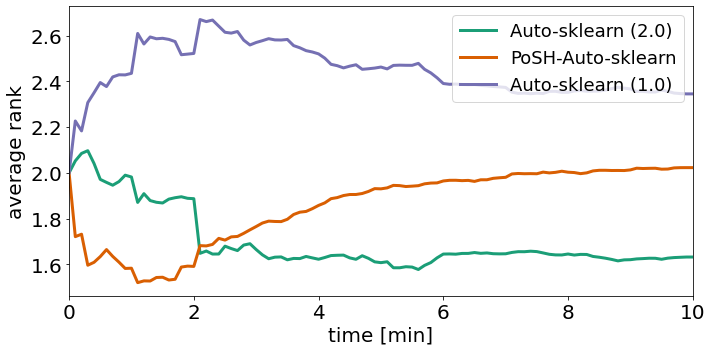

Plotting 3 models
0 / 200
50 / 200
100 / 200
150 / 200


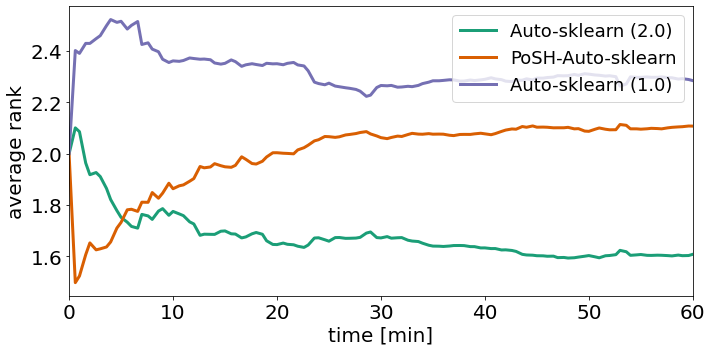

In [9]:
for HORIZON in (10, 60):
    model_list = []
    for m in valid_pretty[HORIZON].keys():
        if m[1] in use_ensemble:
            model_list.append(m)
    rank(model_list, res_dc, valid_pretty, HORIZON, task_ids_sorted_by_num_features, n_iter=200, 
         steplength=max(1, int(HORIZON * 60 / 100)), legend=True)
    plt.legend(fontsize=style_dc["fontsize"] - 2, loc="upper right")
    plt.tight_layout()
    plt.savefig('/tmp/RQ1_%sMIN_rank.pdf' % str(HORIZON))
    plt.show()

In [10]:
def table_per_dataset(model_list, res_dc, valid_pretty, horizon,
                      task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds):
    # Generate data for final table and statistical testing
    tab_data = {}

    for mode in model_list:
        assert mode in valid_pretty[horizon], (mode, valid_pretty[horizon].keys())
        tab_data[valid_pretty[horizon][mode]] = {}
        # Use label, not actual key
        # Get means per tid
        for tid in task_ids_sorted_by_num_features:
            tmp = pd.DataFrame(res_dc[horizon][tid][mode]).sort_index(axis=1).ffill(axis=1).iloc[:, -1]
            assert tmp.shape == (n_seeds, )
            tmp = (tmp - min_diff_dc[tid][0]) / min_diff_dc[tid][1]
            tab_data[valid_pretty[horizon][mode]][tid] = tmp.mean()
    tab_data = pd.DataFrame(tab_data)
    return tab_data

tab_data_per_horizon = {}
for h in (10, 60):
    horizon_list = sorted(list(valid_pretty.keys()))
    model_list = []
    for m in valid_pretty[h].keys():
        if m[1]:
            model_list.append(m)

    tab_data = table_per_dataset(model_list, res_dc, valid_pretty, h,
                                 task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
    tab_data_per_horizon[h] = tab_data

In [11]:
tab_data_per_horizon[10]

""


In [12]:
tab_data_per_horizon[60]

""
